In [1]:
from google.colab import files
uploaded = files.upload()

Saving processed_zone_features.csv to processed_zone_features.csv


In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

# 1. Load data
df = pd.read_csv('processed_zone_features.csv')

# 2. Fill missing values with column medians
numeric_cols = df.select_dtypes(include=np.number).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# 3. Convert numeric Risk to binary classes: High (>= median), Medium (< median)
threshold = df['Risk'].median()
df['Risk_Level'] = df['Risk'].apply(lambda x: 'High' if x >= threshold else 'Medium')

# 4. Select mining-relevant features
features = df[[
    'NO2_Differential',
    'Environmental_Stress',
    'WaterLevel_Mean',
    'DistanceToForest',
    'Water_Pollution_Interaction'
]]

# 5. Encode target
le = LabelEncoder()
target = le.fit_transform(df['Risk_Level'])  # High=1, Medium=0

# 6. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    features, target,
    test_size=0.2,
    stratify=target,
    random_state=42
)

# 7. Scale features
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 8. Train Extra Trees Classifier
model = ExtraTreesClassifier(
    n_estimators=200,
    max_depth=6,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42
)
model.fit(X_train_scaled, y_train)

# 9. Evaluate
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# 10. Save model artifacts
joblib.dump(model, 'mining_risk_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')
joblib.dump(le, 'label_encoder.pkl')
print("Model saved successfully!")


Model Accuracy: 81.82%

Classification Report:
              precision    recall  f1-score   support

        High       0.83      0.83      0.83         6
      Medium       0.80      0.80      0.80         5

    accuracy                           0.82        11
   macro avg       0.82      0.82      0.82        11
weighted avg       0.82      0.82      0.82        11

Model saved successfully!


In [37]:
from google.colab import files
files.download('mining_risk_model.pkl')
files.download('feature_scaler.pkl')
files.download('label_encoder.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

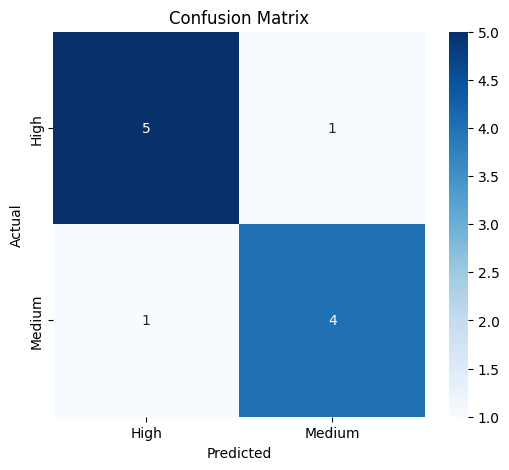

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


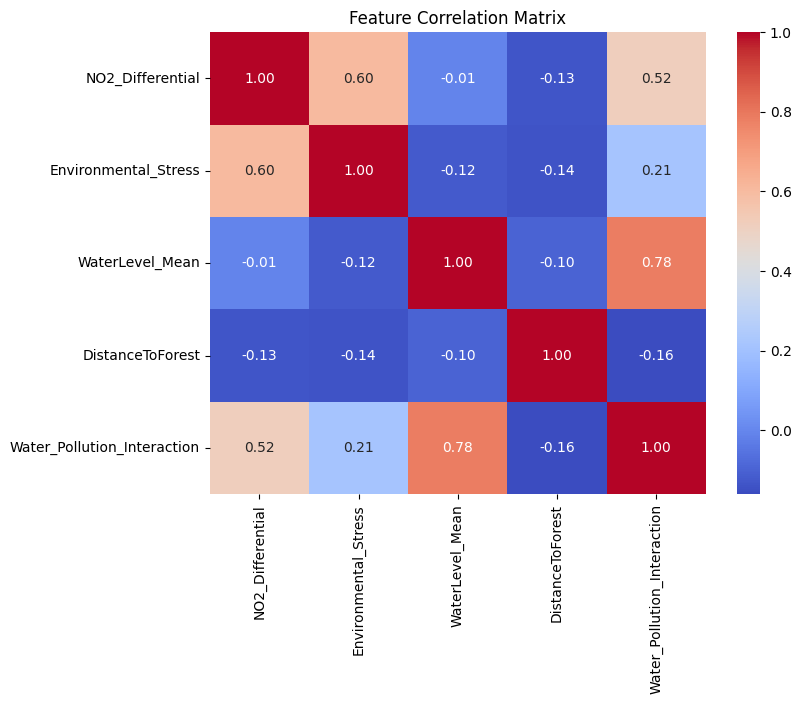

In [33]:
plt.figure(figsize=(8, 6))
corr = features.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()


In [34]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

        High       0.83      0.83      0.83         6
      Medium       0.80      0.80      0.80         5

    accuracy                           0.82        11
   macro avg       0.82      0.82      0.82        11
weighted avg       0.82      0.82      0.82        11



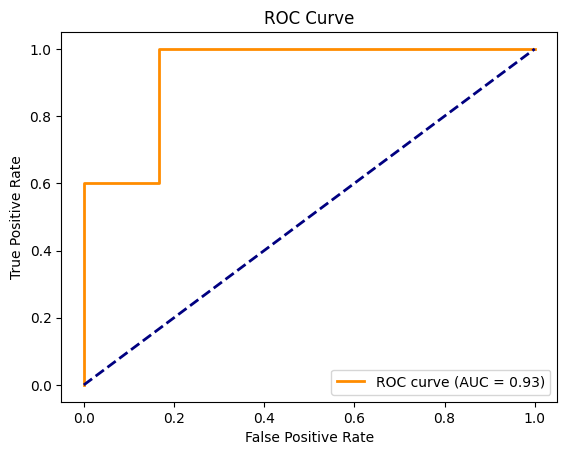

In [35]:
from sklearn.metrics import roc_curve, auc

if len(le.classes_) == 2:
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
